In [1]:
import pandas as pd
from gensim import corpora, models, similarities
from nltk.tokenize import TweetTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('std_data/MCTest/mc500/mc500.test.csv',index_col=0)

In [3]:
#train_df = train_df[(train_df.question_type=='one')].reset_index(drop=True)
print(list(train_df.columns))


['id', 'author', 'work_times', 'article', 'question_type', 'question', 'A', 'B', 'C', 'D', 'answer']


In [4]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

def rmv_stwd(sentence):
    return [w for w in sentence if not w in stop_words] 
    

def compare(options,query,argmax=True):
    options = [word_tokenize(t.lower()) for t in  options] #lower + tokenise
    #options = [rmv_stwd(opt) for opt in options] 
    
    dictionary = corpora.Dictionary(options)
    feature_cnt = len(dictionary.token2id)
    corpus = [dictionary.doc2bow(opt) for opt in options]
    tfidf = models.TfidfModel(corpus) 

    kw_vector = dictionary.doc2bow(word_tokenize(query.lower()))
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
    sim = index[tfidf[kw_vector]]
    if argmax:
        return np.argmax(sim)
    return sim

In [5]:
i=0
print("Passage: " + train_df['article'][i] +"\n")
print("Question: " + train_df['question'][i])


options = [train_df['A'][i],train_df['B'][i],train_df['C'][i],train_df['D'][i]]
print("Options: ")
print("A: " + train_df['A'][i])
print("B: " + train_df['B'][i])
print("C: " + train_df['C'][i])
print("D: " + train_df['D'][i])

print("Expected Answer: " + train_df['answer'][i])

print("------")
print("Model Prediction")
most_related_sent = compare(train_df['article'][i].split('.'),train_df['question'][i])
print("Most related sentence: " + train_df['article'][i].split('.')[most_related_sent])
most_related_ans=compare(options,train_df['article'][i].split('.')[most_related_sent])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(train_df['answer'])[i]
le.inverse_transform([most_related_ans])[0]
print("Predicted Answer: " + le.inverse_transform([most_related_ans])[0])




Passage: It was Sally's birthday. She was very excited. She was going to have a sleepover at her house for her birthday. She invited all of her best friends. The party was at 1 on Saturday. Jessica, Erin, and Cathy all arrived at 1, but Jennifer was late. She did not come until 2, because she could not find her other shoe. The first thing they all did was go swimming in her pool. They had so much fun. They played with the foam noodles in the pool. Erin accidentally kicked Jennifer's leg in the pool. After they swam, everyone rinsed off and went inside. They ate cake, opened presents, and watched TV. After it got dark, they ran up and down the stairway, played telephone, and told spooky stories. Sally tripped going down the stairs and hurt her foot, but it felt better soon after. Cathy got scared when they were telling stories, and wanted to call her mom to go home. The other girls told her that it is only a story. She felt better. They all fell asleep at 11. Sally was the first to wake

In [6]:
n = 1 #related sentences
y_pred = []
for i in range(len(train_df)):
    try:
        sentences = train_df['article'][i].split('.')
        # find 3 most related sentence
        arr = compare(sentences,train_df['question'][i],False)
        idx = (-arr).argsort()[:n]

        #most_relevant_s = sentences[idx]
        most_relevant_s = '.'.join([sentences[i] for i in idx])

        options = [train_df['A'][i],train_df['B'][i],train_df['C'][i],train_df['D'][i]]
        y_pred.append(compare(options,most_relevant_s))
    except Exception as e :
        print(e)
        y_pred.append('e')

In [7]:
y_true = train_df['answer']
y_pred = le.inverse_transform(y_pred)

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=le.classes_))

Classification Report:
              precision    recall  f1-score   support

           A       0.36      0.75      0.49       141
           B       0.56      0.36      0.44       146
           C       0.58      0.45      0.50       145
           D       0.60      0.36      0.45       168

    accuracy                           0.47       600
   macro avg       0.53      0.48      0.47       600
weighted avg       0.53      0.47      0.47       600



[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C'), Text(0, 3.5, 'D')]

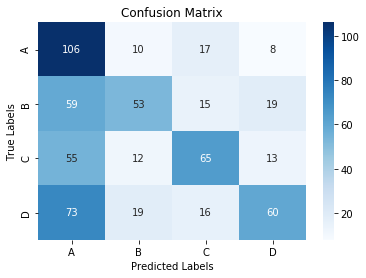

In [45]:
cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)